# COGS 108 - Final Project (change this to your project's title)

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [  ] YES - make available
* [  ] NO - keep private

# Overview

*Fill in your overview here*

# Names

- Anna Wang
- Chloe Salem
- Kristy Liou
- Maxtierney Arias
- Zeven Vidmar Barker

<a id='research_question'></a>
# Research Question

Can we predict which state in the USA will be covid-free first based on current hospital records, state regulations, and population?

<a id='background'></a>

## Background & Prior Work

**Background**

This research question came to be of interest to our group due to the recent release of COVID-19 vaccinations in the US. On February 11th, President Biden and his administration claimed to have finalized deals for another 200 million doses of the two coronavirus vaccines (Moderna and Pfizer) authorized in the United States, supposedly giving the country enough vaccines to cover every American adult by the end of July 2021.
Within the course of this pandemic thus far, different states are evidently handling the spread of COVID-19 inconsistently. Confirmed COVID cases in the USA increased rapidly during mid-March and each state administered different shelters in place, lockdown, social distancing, and essential activity restrictions to reduce and slow down the spread of the virus. However, even with these different restrictions in place, citizens of these states do not always follow these guidelines as they are supposed to which can lead to further spread of the virus despite the state’s intentions.
With this information in mind and Biden’s new vaccination plan announced, we were curious as to which state would be free of COVID first based on how that state is currently doing in terms of hospitalized covid cases, the current amount of vaccinated state citizens, and the population of each state.


**Prior Work**

Prior to our research project, there have been predictions made about when COVID-19 will end in the US. In an article by McKinsey & Company, they believed that the United States will most likely go back to normal in the second quarter of 2021 and obtain herd immunity in the third and fourth quarters. In this article, they mainly talk about when the US in general will transition back to normalcy assuming that vaccines are being administered at the pace they are currently being rolled out. However, they do not take into account each state’s individual activity regarding hospitalization and whether citizens are actually following COVID guidelines but rather approaches a more general outlook on the situation.

References (include links):
- 1) <a href="https://ballotpedia.org/States_that_did_not_issue_stay-at-home_orders_in_response_to_the_coronavirus_(COVID-19">Different States’ Approaches to COVID-19 Stay at Home Orders</a>
- 2) [Biden’s Announcement on Increased Vaccine Supply](https://www.whitehouse.gov/briefing-room/statements-releases/2021/02/02/fact-sheet-president-biden-announces-increased-vaccine-supply-initial-launch-of-the-federal-retail-pharmacy-program-and-expansion-of-fema-reimbursement-to-states/)
- 3) [Predicting when the COVID-19 Pandemic Will End](https://www.mckinsey.com/industries/healthcare-systems-and-services/our-insights/when-will-the-covid-19-pandemic-end#)
- 4) [When will COVID-19 End? Data-Driven Prediction](https://web.persi.or.id/images/2020/data/covid19_prediction_paper.pdf)

# Hypothesis


We believe that states that are distributing vaccinations at a higher rate, have lower overall populations, and have hospitals that are operating below full capacity will be COVID-free first. Based on how states are operating currently, we believe that one of the Midwestern (Nebraska, Kansas, etc) or Western States (Oregon, Utah, Wyoming) will be COVID free first.

# Dataset(s)

To answer our question, we will utilize data on hospital capacity by state, vaccinations in each state, and COVID cases by state, combined with population data sourced from the US Census. 

- Dataset Name: **Population, Population Changes, and Estimates**
- Link to the dataset: https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/national/totals/nst-est2020.csv
- Number of observations: The US Census dataset from 2010 includes populations of the country, states, and regions as well as estimates of each for every year leading up to 2020. This dataset is the best available given that the 2020 census is still being processed.


- Dataset Name: **US State Vaccinations**
- Link to the dataset: https://github.com/owid/covid-19-data/blob/master/public/data/vaccinations/us_state_vaccinations.csv
- It has 2104 observations, which include data on how many people from each state has been vaccinated starting from January 12, 2021.  These observations are broken down by day, which will allow us to analyze the rate at which vaccines are being received and distributed in each state. The dataset features the total number of vaccinations a state has each day with the total number of vaccinations distributed per day.


- Dataset Name: **COVID Tracking**
- Link to the dataset: https://covidtracking.com/data
- It has 2,006 observations, that shows us the number of COVID cases for each state in the US since January 12, 2020, along with patient hospitalization data by state, data on deaths, and COVID testing information. We will be utilizing hospitalization data and testing information.


# Setup

In [1]:
## YOUR CODE HERE
# pip install -U seaborn
# pip install plotly
#conda install -c plotly plotly-orca==1.2.1

#importing needed libraries
import pandas as pd
import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
from datetime import datetime

# reading data sets
population = pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/national/totals/nst-est2020.csv")
vaccinations = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv')
case_tracking = pd.read_csv('https://covidtracking.com/data/download/all-states-history.csv')
state_code = pd.read_csv('https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv')

# Data Cleaning

**Part (1)**
First we cleaned the population dataset by all of the columns except for state and estimate 2020 population. Then for the case tracking and vaccination dataset, we removed all of the columns that did not have information regarding the hospitalization, vaccination, and covid cases records. From the case tracking dataset, we removed the columns regarding the death counts. For the vaccination dataset, we removed forms of counting vaccinations we would not need.

In [2]:
# Removed unnecessary columns in Population dataframe
population = population[5::]
population = population[['NAME', 'POPESTIMATE2020']]
population.rename(columns={"NAME": "state", "POPESTIMATE2020": "2020 population"}, errors="raise", inplace=True)
#population.set_index(['NAME'], inplace=True)
#population.set_index(['NAME'], inplace=True)

population.head()

,state,2020 population
5,Alabama,4921532
6,Alaska,731158
7,Arizona,7421401
8,Arkansas,3030522
9,California,39368078


In [3]:
vaccinations.columns

Index(['date', 'location', 'total_vaccinations', 'total_distributed',
       'people_vaccinated', 'people_fully_vaccinated_per_hundred',
       'total_vaccinations_per_hundred', 'people_fully_vaccinated',
       'people_vaccinated_per_hundred', 'distributed_per_hundred',
       'daily_vaccinations_raw', 'daily_vaccinations',
       'daily_vaccinations_per_million', 'share_doses_used'],
      dtype='object')

In [4]:
# Removed unnecessary columns in vaccinations and renamed for easier readability 
vaccinations = vaccinations.drop(['daily_vaccinations_per_million', 'share_doses_used', 'daily_vaccinations_per_million', 'share_doses_used', 'daily_vaccinations_raw','people_fully_vaccinated_per_hundred','people_vaccinated_per_hundred','total_vaccinations_per_hundred', 'distributed_per_hundred'], 1)
new_names = []
for col in vaccinations.columns:
    new_names.append(col.replace('_', ' '))
vaccinations.rename(columns=dict(zip(vaccinations.columns, new_names)), inplace=True)

In [5]:
# Dropping more unrelated columns to research question - including deaths, antibody tests, negative results, and positive results related to type of test
case_tracking = case_tracking[['date', 'state', 'hospitalized', 'hospitalizedCumulative', 'hospitalizedCurrently', 'hospitalizedIncrease', 'positive', 'totalTestResults', 'totalTestResultsIncrease', 'positiveCasesViral', 'positiveIncrease']]
new_names = []
for name in case_tracking.columns:
    new_names.append((re.sub(r"(\w)([A-Z])", r"\1 \2", name)).lower())
case_tracking.rename(columns=dict(zip(case_tracking.columns, new_names)), inplace=True)

In [6]:
case_tracking.head()

,date,state,hospitalized,hospitalized cumulative,hospitalized currently,hospitalized increase,positive,total test results,total test results increase,positive cases viral,positive increase
0,2021-03-07,AK,1293.0,1293.0,33.0,0,56886.0,1731628.0,0,NaN,0
1,2021-03-07,AL,45976.0,45976.0,494.0,0,499819.0,2323788.0,2347,392077.0,408
2,2021-03-07,AR,14926.0,14926.0,335.0,11,324818.0,2736442.0,3380,255726.0,165
3,2021-03-07,AS,NaN,NaN,NaN,0,0.0,2140.0,0,NaN,0
4,2021-03-07,AZ,57907.0,57907.0,963.0,44,826454.0,7908105.0,45110,769935.0,1335


In [7]:
vaccinations.head()

,date,location,total vaccinations,total distributed,people vaccinated,people fully vaccinated,daily vaccinations
0,2021-01-12,Alabama,78134.0,377025.0,70861.0,7270.0,NaN
1,2021-01-13,Alabama,84040.0,378975.0,74792.0,9245.0,5906.0
2,2021-01-14,Alabama,92300.0,435350.0,80480.0,NaN,7083.0
3,2021-01-15,Alabama,100567.0,444650.0,86956.0,13488.0,7478.0
4,2021-01-16,Alabama,NaN,NaN,NaN,NaN,7498.0


**Part (2)**
After removing the unnecessary columns, we took a dataframe that contains information about the different identifies of state names and unabbreviated the case tracking dataset's state column in order to match the format of the vaccination dataset location column. Then we removed the information of the territories of the US in both dataset because we will only analyze US states. After cleaning the case tracking and vaccination dataset, we merge using a left join based off of the state and date variable to create one big dataset.

This new dataset will contain case tracking variables and vaccination variable for each corresponding state and date. Since vaccination data has only started in 1/3/2021, information regarding vaccination prior to that data will be null values.

In [8]:
# Converting case-tracker state from Abbreviation
for i,j in state_code.iterrows():
    state_code.loc[i]['Abbreviation']
    case_tracking.loc[case_tracking.state == state_code.loc[i]['Abbreviation'], ['state']] = state_code.loc[i]['State']

# Removing the US territory data from the datasets
territories = ['AS', 'GU', 'MP', 'VI', 'PR', 'DC', 'American Samoa', 
               'Federated States of Micronesia', 'Indian Health Svc', 'Guam','Long Term Care',
               'Virgin Islands','Veterans Health', 'Republic of Palau','Puerto Rico', 'Bureau of Prisons',
             'Marshall Islands','Northern Mariana Islands','Dept of Defense','United States', 'District of Columbia']
case_tracking = case_tracking[~case_tracking.state.isin(territories)]
vaccinations = vaccinations[~vaccinations.location.isin(territories)]
vaccinations.loc[vaccinations.location == 'New York State', ['location']] = 'New York'

# Checking if case_tracking and vaccinations have the same states
for i in case_tracking['state'].unique():
    if i not in vaccinations['location'].unique():
        print(i)
vaccinations.rename(columns={'location':'state'},inplace=True)

# Joining case_tracking and vaccination dataframes into one
merged_data = pd.merge(case_tracking, vaccinations, on = ['date', 'state'], how='right')
merged_data.head(-1)

,date,state,hospitalized,hospitalized cumulative,hospitalized currently,hospitalized increase,positive,total test results,total test results increase,positive cases viral,positive increase,total vaccinations,total distributed,people vaccinated,people fully vaccinated,daily vaccinations
0,2021-03-07,Alaska,1293.0,1293.0,33.0,0.0,56886.0,1731628.0,0.0,NaN,0.0,295046.0,426715.0,180563.0,113792.0,4329.0
1,2021-03-07,Alabama,45976.0,45976.0,494.0,0.0,499819.0,2323788.0,2347.0,392077.0,408.0,1110132.0,1628350.0,709736.0,398035.0,23947.0
2,2021-03-07,Arkansas,14926.0,14926.0,335.0,11.0,324818.0,2736442.0,3380.0,255726.0,165.0,765260.0,1088150.0,487494.0,273608.0,16564.0
3,2021-03-07,Arizona,57907.0,57907.0,963.0,44.0,826454.0,7908105.0,45110.0,769935.0,1335.0,2162602.0,2623735.0,1421436.0,729803.0,52879.0
4,2021-03-07,California,NaN,NaN,4291.0,0.0,3501394.0,49646014.0,133186.0,3501394.0,3816.0,10634752.0,13885120.0,7218393.0,3352223.0,259101.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994,2021-03-12,Wisconsin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1944768.0,2215335.0,1240451.0,691938.0,41145.0
2995,2021-03-08,Wyoming,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185580.0,236065.0,114824.0,68219.0,4120.0
2996,2021-03-09,Wyoming,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185813.0,246125.0,115046.0,68289.0,4148.0
2997,2021-03-10,Wyoming,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190180.0,259495.0,116799.0,70919.0,3895.0


**Part (3)** Here, we further took a look at our dataset's variables. We specifically looked at California's data to see which columns seem to be missing values. From below, it seemed like the columns `hospitialized` and `hospitalized cumulative` seemed to be missing alot of values. We then looked at the entire dataset to see if California had any information within the these columns prior to the date 1/12/2021, and it did not, so we deleted the columns.  

Then further looking into the dataset, it seems like certain values at NaN at the start of the datasets, as well as recent rows that have been added, but information has not yet been put in. We delete the recent rows because it contains mostly NaN values for majority of the states. We also remove the some of the earliest dates because it is difficult to imputate and estimate the data values without knownledge of prior day values.

After removing those specific rows with the dates, we filted through the dataset and filled in the NaN values with estimates using imputation. This is done with the function `imputation()`.


In [9]:
merged_data.isnull().sum()

date                             0
state                            0
hospitalized                   965
hospitalized cumulative        965
hospitalized currently         250
hospitalized increase          250
positive                       250
total test results             250
total test results increase    250
positive cases viral           870
positive increase              250
total vaccinations             200
total distributed              200
people vaccinated              209
people fully vaccinated        260
daily vaccinations              50
dtype: int64

In [10]:
# Checking wehether some variables are the same 
comparison_column = np.where(merged_data["hospitalized"] == merged_data["hospitalized cumulative"], True, False)
merged_data['hospital check'] = comparison_column
num = merged_data[merged_data['hospital check'] == False]['hospitalized'].count()
print('Checking whether hospitalization column and hospital column are different : ' + str(num))

# Checking on the if there is even data on hospitalized variable in the larger dataset
merged_data2 = pd.merge(case_tracking, vaccinations, on = ['date', 'state'], how='left')
merged_data2.head(-1)
california = merged_data2[merged_data2['state'] == 'California']
num = california['hospitalized'].count()
print('California Hospitalized column count : ' + str(num))

# Since these columns don't have data at all for one state, better to remove it
merged_data = merged_data.drop(columns=['hospitalized', 'hospitalized cumulative', 'positive cases viral'])
merged_data.isnull().sum()

Checking whether hospitalization column and hospital column are different : 0
California Hospitalized column count : 0


date                             0
state                            0
hospitalized currently         250
hospitalized increase          250
positive                       250
total test results             250
total test results increase    250
positive increase              250
total vaccinations             200
total distributed              200
people vaccinated              209
people fully vaccinated        260
daily vaccinations              50
hospital check                   0
dtype: int64

In [11]:
# Remove the rows were there are missing data from the beginning, can't use imputation
merged_data = merged_data[merged_data['date'] != '2021-01-14'] 
merged_data = merged_data[merged_data['date'] != '2021-01-13']
merged_data = merged_data[merged_data['date'] != '2021-01-12']

# Remove rows that vaccine data has recently been added on, but not hospital data 
merged_data = merged_data[merged_data['date'] != '2021-03-09']
merged_data = merged_data[merged_data['date'] != '2021-03-08']
merged_data = merged_data[merged_data['date'] != '2021-03-10']
merged_data = merged_data[merged_data['date'] != '2021-03-11']
merged_data = merged_data[merged_data['date'] != '2021-03-12']

# To check the null values and reset the indexes
merged_data.isnull().sum()
merged_data = merged_data.reset_index()
merged_data.tail(5)

,index,date,state,hospitalized currently,hospitalized increase,positive,total test results,total test results increase,positive increase,total vaccinations,total distributed,people vaccinated,people fully vaccinated,daily vaccinations,hospital check
2595,2595,2021-01-15,Vermont,45.0,0.0,9734.0,788759.0,9581.0,161.0,32470.0,74000.0,28355.0,4100.0,2238.0,False
2596,2596,2021-01-15,Washington,1105.0,0.0,283777.0,4153214.0,24797.0,2575.0,242606.0,696175.0,200682.0,31581.0,15680.0,True
2597,2597,2021-01-15,Wisconsin,998.0,119.0,563866.0,5745570.0,29446.0,2706.0,169803.0,437900.0,151387.0,17108.0,10850.0,True
2598,2598,2021-01-15,West Virginia,717.0,0.0,106649.0,1709911.0,21808.0,1430.0,134207.0,205475.0,113034.0,21162.0,10292.0,False
2599,2599,2021-01-15,Wyoming,89.0,4.0,48909.0,549805.0,7489.0,208.0,22745.0,58775.0,19931.0,2803.0,2093.0,True


In [12]:
def imputation():
    count = 0
    col = ['total vaccinations', 'total distributed', 'people vaccinated','people fully vaccinated']
    
    for (index_label, row_series) in merged_data.iloc[::-1].iterrows():
        #print('Row Index label : ', index_label)
        #print('Row Content as Series : ', row_series.values)
        if merged_data.loc[index_label, 'date'] == '2021-01-18':
            #state = merged_data.loc[index_label, 'state']
            for i in range(0, len(col)):
                var = col[i]
                upper_bound = merged_data.loc[index_label - 50, var]
                lower_bound = merged_data.loc[index_label + 150, var]

                difference = upper_bound - lower_bound
                avg = difference // 4
                
                merged_data.loc[index_label, var] = upper_bound - avg
                merged_data.loc[index_label + 50, var] = upper_bound - (2*avg)
                merged_data.loc[index_label + 100, var] = upper_bound - (3*avg)
                
                
    columns = merged_data.columns.tolist()
    for (index_label, row_series) in merged_data.iloc[::-1].iterrows():
        merged_data.loc[index_label, :].isnull()
        null_val = merged_data.loc[index_label, :].isnull().tolist()
        if (merged_data.loc[index_label, 'date'] == '2021-01-13'):
            continue
        #print(merged_data.loc[index_label, columns[i]])
        for i in range(0, len(null_val)):
            if null_val[i]:
                upper = merged_data.loc[index_label - 50, columns[i]]
                lower = merged_data.loc[index_label + 50, columns[i]]
                difference = upper - lower
                avg = difference / 2

                merged_data.loc[index_label, columns[i]] = merged_data.loc[index_label + 50, columns[i]] + avg
        
imputation()
merged_data.isnull().sum()

index                          0
date                           0
state                          0
hospitalized currently         0
hospitalized increase          0
positive                       0
total test results             0
total test results increase    0
positive increase              0
total vaccinations             0
total distributed              0
people vaccinated              0
people fully vaccinated        0
daily vaccinations             0
hospital check                 0
dtype: int64

In [13]:
merged_data.head(-1)

,index,date,state,hospitalized currently,hospitalized increase,positive,total test results,total test results increase,positive increase,total vaccinations,total distributed,people vaccinated,people fully vaccinated,daily vaccinations,hospital check
0,0,2021-03-07,Alaska,33.0,0.0,56886.0,1731628.0,0.0,0.0,295046.0,426715.0,180563.0,113792.0,4329.0,True
1,1,2021-03-07,Alabama,494.0,0.0,499819.0,2323788.0,2347.0,408.0,1110132.0,1628350.0,709736.0,398035.0,23947.0,True
2,2,2021-03-07,Arkansas,335.0,11.0,324818.0,2736442.0,3380.0,165.0,765260.0,1088150.0,487494.0,273608.0,16564.0,True
3,3,2021-03-07,Arizona,963.0,44.0,826454.0,7908105.0,45110.0,1335.0,2162602.0,2623735.0,1421436.0,729803.0,52879.0,True
4,4,2021-03-07,California,4291.0,0.0,3501394.0,49646014.0,133186.0,3816.0,10634752.0,13885120.0,7218393.0,3352223.0,259101.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2594,2594,2021-01-15,Virginia,3147.0,146.0,422634.0,4730680.0,23966.0,4795.0,244234.0,852725.0,214732.0,28164.0,17876.0,True
2595,2595,2021-01-15,Vermont,45.0,0.0,9734.0,788759.0,9581.0,161.0,32470.0,74000.0,28355.0,4100.0,2238.0,False
2596,2596,2021-01-15,Washington,1105.0,0.0,283777.0,4153214.0,24797.0,2575.0,242606.0,696175.0,200682.0,31581.0,15680.0,True
2597,2597,2021-01-15,Wisconsin,998.0,119.0,563866.0,5745570.0,29446.0,2706.0,169803.0,437900.0,151387.0,17108.0,10850.0,True


**DATA SET ACKNOWNLEDGEMENT**

We acknownledge that there are a number of NaN values within our dataset possibly due to states inability to record for a certain day. Due to the merge, there is also alot of NaN values for vaccination information of each state with dates prior to the 1/12/2021. 

With the variables related to vaccination, we plan to change their values to 0 prior to the date 1/12/2021. With rows with date values after 1/12/2021, we plan to use imputation to estimate their values given the previous and next day values of that same state. We also plan to use imputation with the other variables, such as hospitialization information and covid cases in order to get rid of the null values.

# Data Analysis & Results

Include cells that describe the steps in your data analysis.

**Part 1**
First we decided to analyze our population dataset by looking at the histogram and distribution plot.
From the results we see that more than half of US states have less than 10 million in population. After we made a barplot that shows each state's population, where we can see which states have a larger population count.

Then, we created a heatmap showing proportion of positive cases for COVID within the USA. This graph gives us an idea of which state in the US had a higher proportion of positive cases in regards to their population number.

/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Histogram of US State Population')]

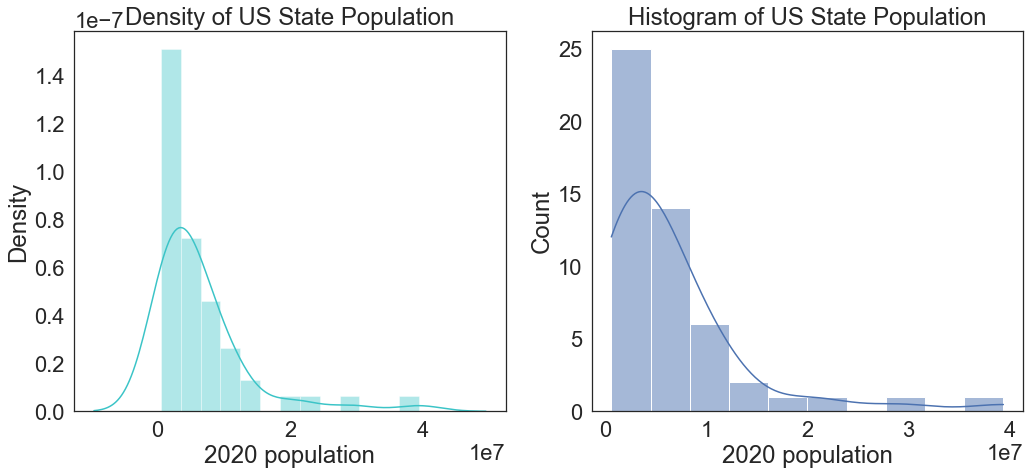

In [14]:
sns.set(style="white", font_scale=2)
plt.rcParams['figure.figsize'] = (17, 7)

plt.subplot(1, 2, 1)
sns.distplot(population['2020 population'], color='#3BC4C7').set(title="Density of US State Population")
plt.subplot(1, 2, 2)
sns.histplot(population['2020 population'], bins=10, kde=True).set(title="Histogram of US State Population")

[Text(0.5, 1.0, 'Population Of US States')]

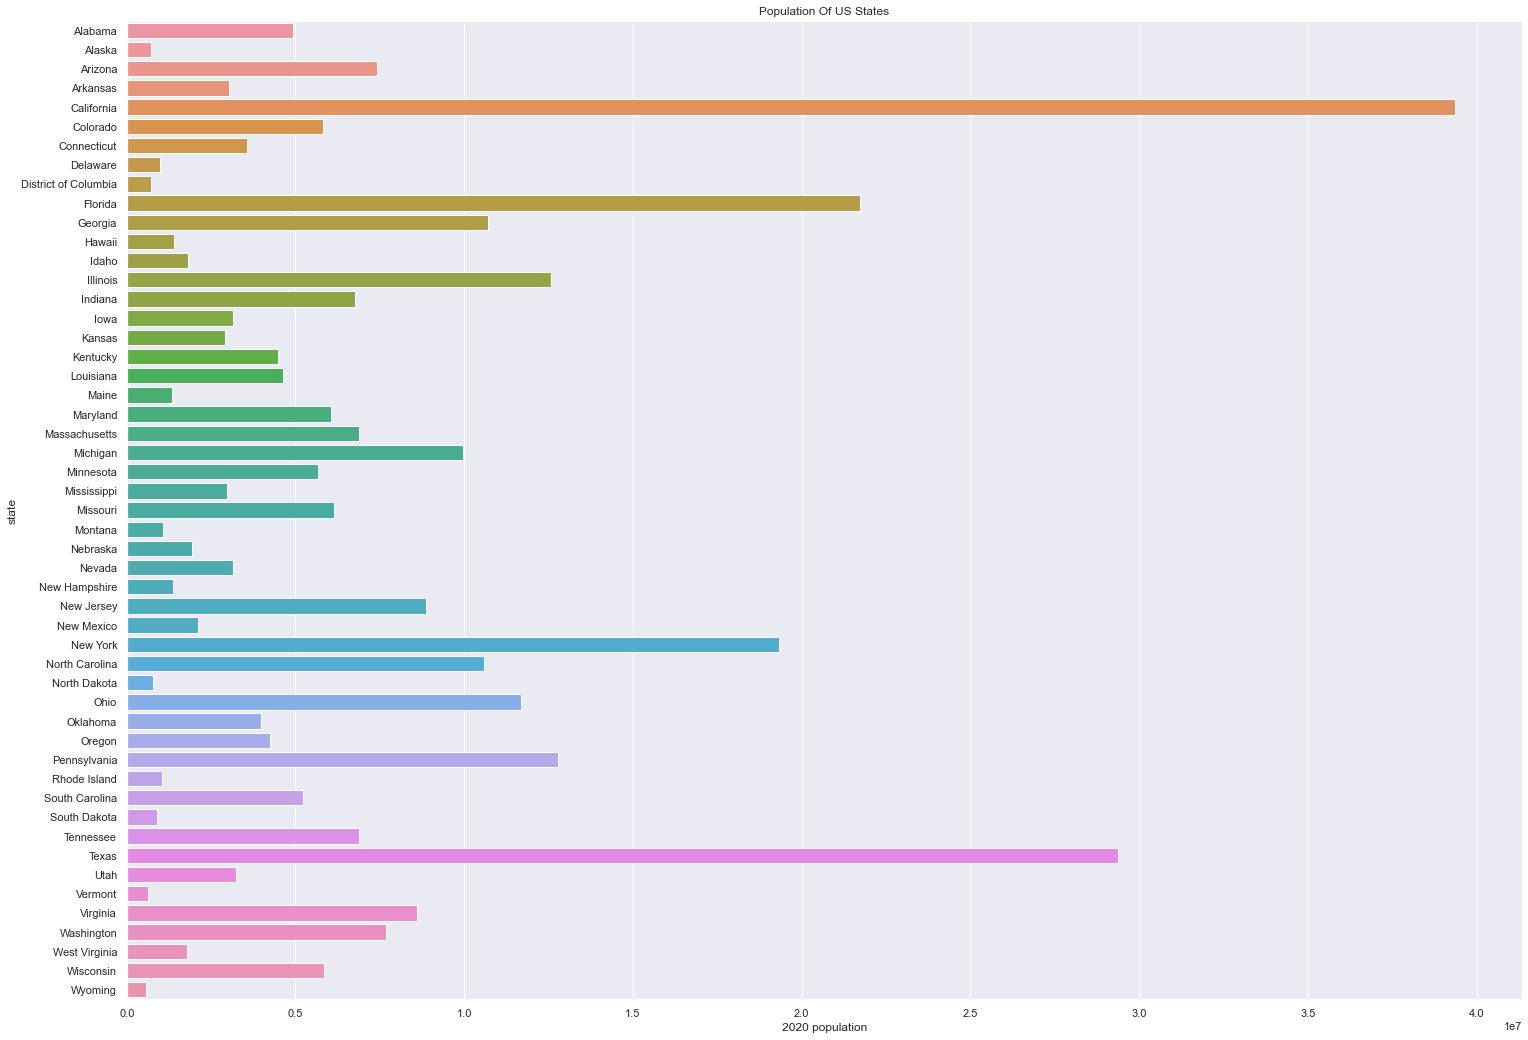

In [15]:
sns.set(rc={'figure.figsize':(25,18)})
sns.barplot(x=population['2020 population'], y='state', data=population).set(title="Population Of US States")

In [16]:
most_recent = merged_data[merged_data['date'] == '2021-02-23']
most_recent = pd.merge(most_recent, population, on = ['state'], how='left')
#most_recent['proportion increase'] = most_recent['positive increase']/most_recent['2020 population']
most_recent['proportion positive'] = most_recent['positive']/most_recent['2020 population']

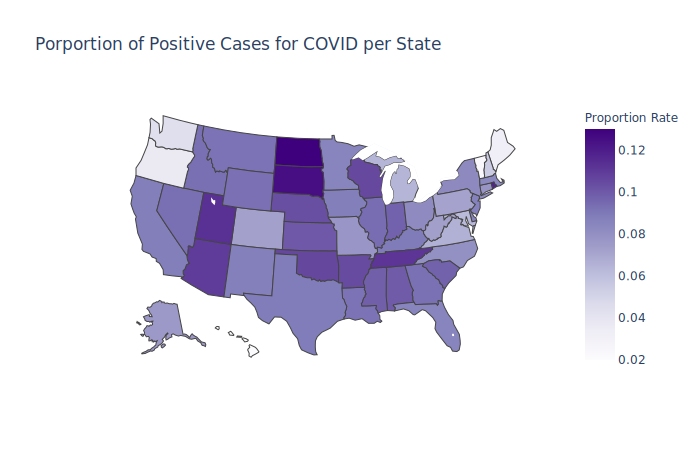

In [17]:
for i,j in state_code.iterrows():
    most_recent.loc[most_recent.state == state_code.loc[i]['State'], ['state']] = state_code.loc[i]['Abbreviation']

pio.renderers

fig = go.Figure(data=go.Choropleth(
    locations=most_recent['state'], # Spatial coordinates
    z = most_recent['proportion positive'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Purples',
    colorbar_title = "Proportion Rate",
))

fig.update_layout(
    title_text = 'Porportion of Positive Cases for COVID per State',
    geo_scope='usa', # limite map scope to USA
)

fig.show(renderer="svg")

**Part 2**
Next we decide to take the column `people vaccinated` to calculate the proportion of people vaccinated per state. When calculating the proportion, we used the most recent rows of each state and stored it in a seperate dataset called `most_recent`. After calulating the proportion and inserting the values in a new column `proportion vaccination`, we made a barplot, histogram, and distribution plot showing our results. We then graphed a distribution of the number of people fully vaccinated and hospitalized currently.

From the barplot, we can compare the different proportion from each state. From the histogram and distribution graph, we can see how many states have similar vaccination proportion. 
From the density graphs we can see that they skewed to the right.

In [18]:
most_recent['proportion vaccination'] = most_recent['people vaccinated']/most_recent['2020 population']
most_recent['people vaccinated'].isnull().sum()

0

[Text(0.5, 1.0, 'Proportion of US State Populations')]

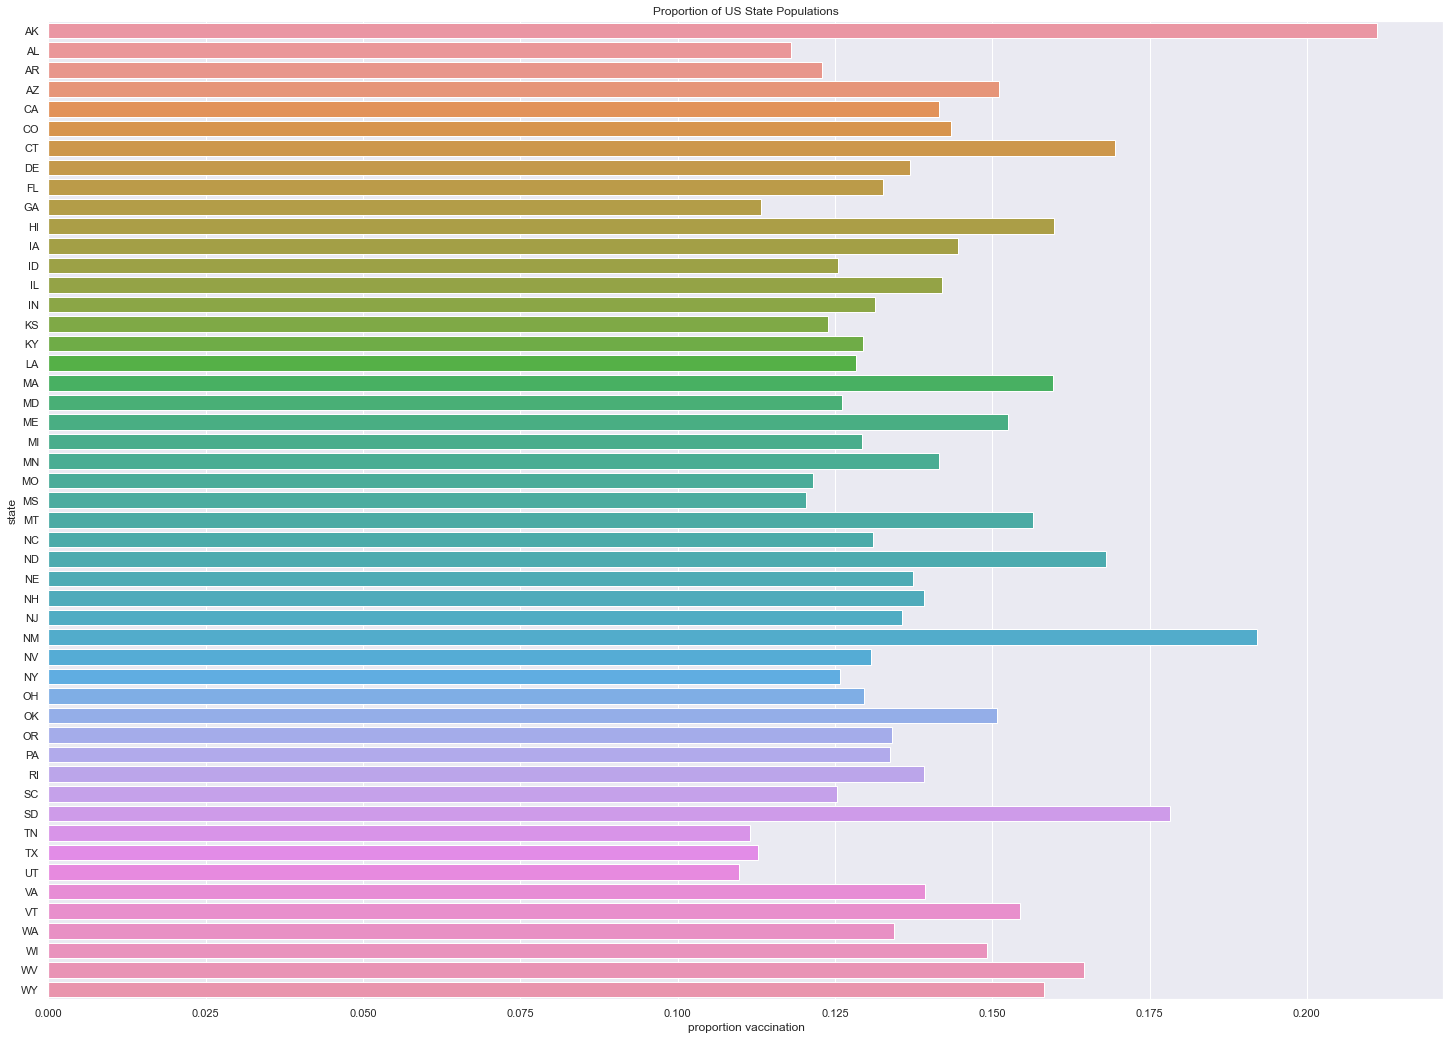

In [19]:
sns.set(rc={'figure.figsize':(25,18)})
sns.barplot(x=most_recent['proportion vaccination'], y='state', data=most_recent).set(title="Proportion of US State Populations")

/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



<AxesSubplot:title={'center':'Histogram of Proportion of People Vaccinated for each US State'}, xlabel='proportion vaccination', ylabel='Count'>

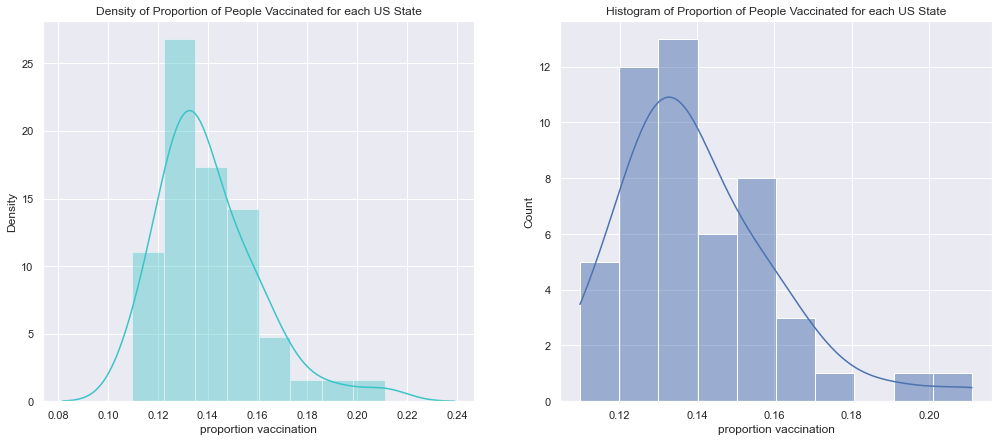

In [20]:
sns.set(rc={'figure.figsize':(17,7)})
plt.subplot(1, 2, 1)
sns.distplot(most_recent['proportion vaccination'], color='#3BC4C7').set(title="Density of Proportion of People Vaccinated for each US State")
plt.subplot(1, 2, 2)
sns.histplot(most_recent['proportion vaccination'], bins=10, kde=True).set(title="Histogram of Proportion of People Vaccinated for each US State")
plt.subplot(1, 2, 2)

/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



[Text(0.5, 1.0, 'Density of People Hospitalized Currently for each US State')]

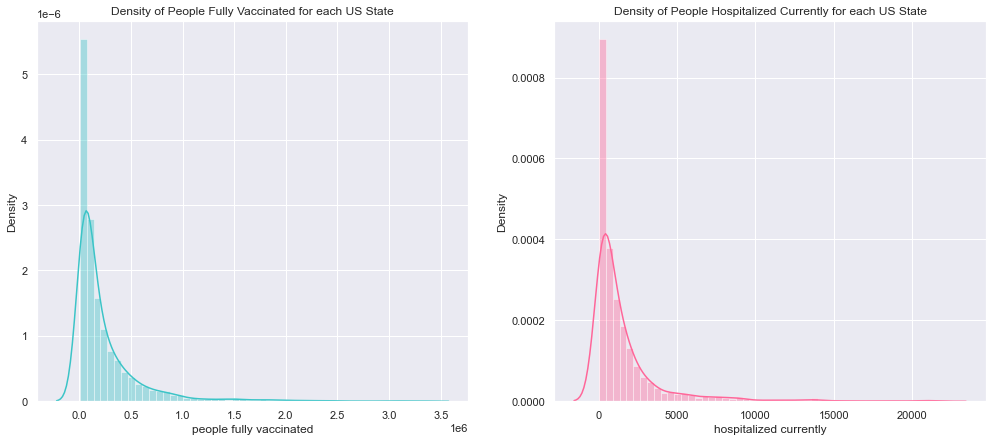

In [21]:
plt.subplot(1, 2, 1)  
sns.distplot(merged_data['people fully vaccinated'], color='#3BC4C7').set(title="Density of People Fully Vaccinated for each US State")
plt.subplot(1, 2, 2)
sns.distplot(merged_data['hospitalized currently'], color='#FF6699').set(title="Density of People Hospitalized Currently for each US State")

We further decided to create a heat map of the proportion vaccination values within the US. This shown below, we can easily see state with a darker green color showing higher proportion values. This gives us an idea of the states that have a higher vaccination percentage with regards to their population.

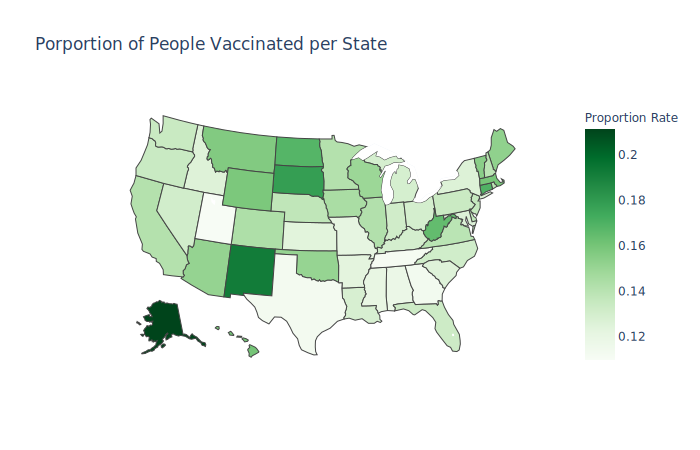

In [22]:
pio.renderers

fig = go.Figure(data=go.Choropleth(
    locations=most_recent['state'], # Spatial coordinates
    z = most_recent['proportion vaccination'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Greens',
    colorbar_title = "Proportion Rate",
))

fig.update_layout(
    title_text = 'Porportion of People Vaccinated per State',
    geo_scope='usa', # limite map scope to USA
)

fig.show(renderer="svg")

**Part 3**
Next we want to explore the hospitialization records across the US using the column `hospitalized currently`. First we created another heat map to display the current proportion of citizen hospitialized per state. We calculated the proportion and placed the result in a new column called `proportion hospitalized`. From this we can which states have higher percentage of hospitialized citizens.

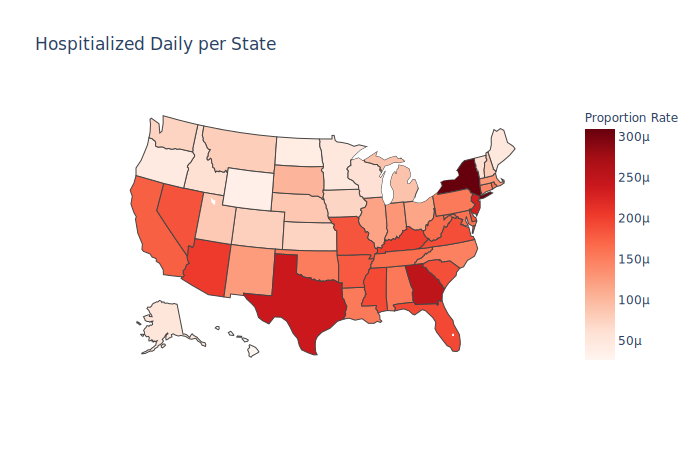

In [23]:
most_recent['proportion hospitalized'] = most_recent['hospitalized currently']/most_recent['2020 population']
fig2 = go.Figure(data=go.Choropleth(
    locations=most_recent['state'], # Spatial coordinates
    z = most_recent['proportion hospitalized'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Proportion Rate",
))

fig2.update_layout(
    title_text = 'Hospitialized Daily per State',
    geo_scope='usa', # limite map scope to USA
)

fig2.show(renderer="svg")

**Part 4**
Here we explored the hospital records and vaccination records of each state with a specific time frame. Since vaccination records started at the date 1/12/2021, we took the merged dataset and filted out the rows with the date before 1/12/2021. 

Since there are too many states to graph, we only looked at certain states like New York, Texas, and Utah. For each state we made two lineplots. One showing the trend of hosipitialization records based off of the current date. The other showing the number of people vaccination based off of the current date.

From the graphs below we can see the different trends of hospital records and vaccination over 1 month. From the graphs we see that all three states have similar shapes within their trends. The line in the hospitalization graphs show a downward trend over the month while more people continue to get vaccinated.

In [24]:
new_york_df = merged_data[merged_data['state'] == 'New York']
sns.set(rc={'figure.figsize':(25,7)})
new_york_df['date'] = pd.to_datetime(new_york_df['date'])
new_york_df2 = new_york_df[(new_york_df['date'] >= '2021-01-12')]
#new_york_df2['hospitalized'].isnull().sum()
#new_york_df2['daily vaccinations'].isnull().sum() = 1 for today's date

/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



[Text(0.5, 1.0, 'Number of People Vaccinated Daily in New York')]

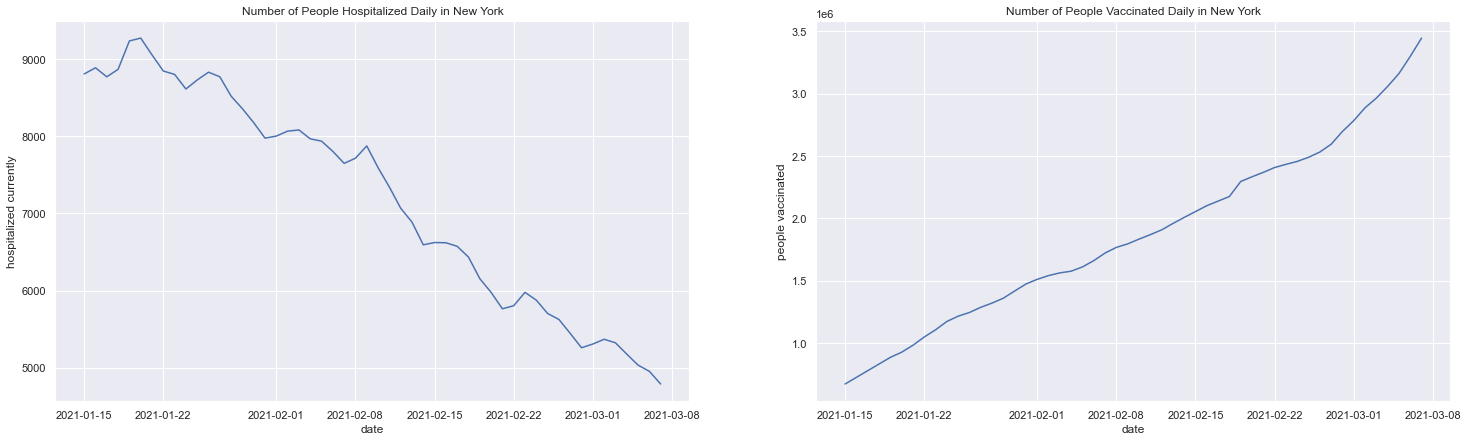

In [25]:
plt.subplot(1, 2, 1)
sns.lineplot(x='date', y='hospitalized currently', data=new_york_df2).set(title='Number of People Hospitalized Daily in New York')
plt.subplot(1, 2, 2)
sns.lineplot(x='date', y='people vaccinated', data=new_york_df2).set(title='Number of People Vaccinated Daily in New York')

/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[Text(0.5, 1.0, 'Number of People Vaccinated Daily in Texas')]

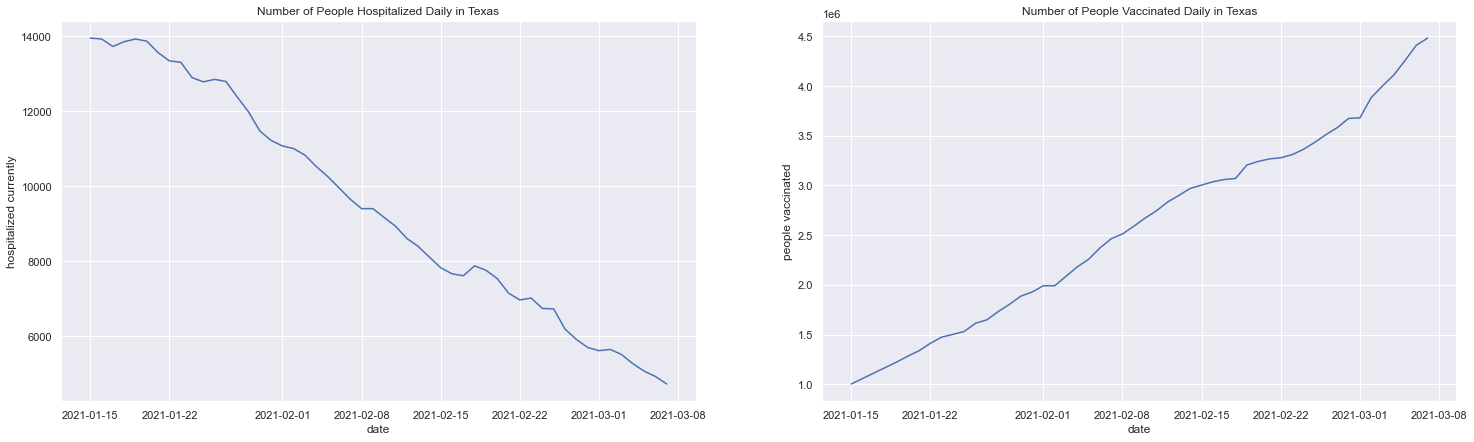

In [26]:
texas_df = merged_data[merged_data['state'] == 'Texas']
texas_df['date'] = pd.to_datetime(texas_df['date'])
texas_df = texas_df[(texas_df['date'] >= '2021-01-12')]
plt.subplot(1, 2, 1)
sns.lineplot(x='date', y='hospitalized currently', data=texas_df).set(title='Number of People Hospitalized Daily in Texas')
plt.subplot(1, 2, 2)
sns.lineplot(x='date', y='people vaccinated', data=texas_df).set(title='Number of People Vaccinated Daily in Texas')

/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[Text(0.5, 1.0, 'Number of People Vaccinated Daily in Utah')]

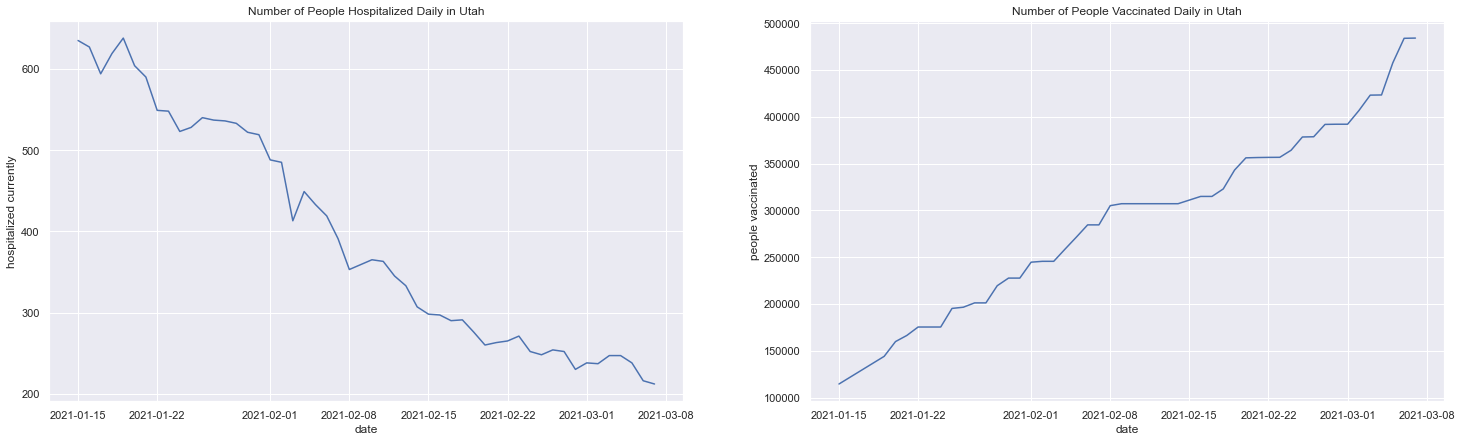

In [27]:
utah_df = merged_data[merged_data['state'] == 'Utah']
utah_df['date'] = pd.to_datetime(utah_df['date'])
utah_df = utah_df[(utah_df['date'] >= '2021-01-12')]
plt.subplot(1, 2, 1)
sns.lineplot(x='date', y='hospitalized currently', data=utah_df).set(title='Number of People Hospitalized Daily in Utah')
plt.subplot(1, 2, 2)
sns.lineplot(x='date', y='people vaccinated', data=utah_df).set(title='Number of People Vaccinated Daily in Utah')

In [28]:
utah_df

,index,date,state,hospitalized currently,hospitalized increase,positive,total test results,total test results increase,positive increase,total vaccinations,total distributed,people vaccinated,people fully vaccinated,daily vaccinations,hospital check
43,43,2021-03-07,Utah,212.0,24.0,374850.0,2910121.0,6828.0,412.0,833167.0,993140.0,483961.0,211948.0,20666.0,True
93,93,2021-03-06,Utah,216.0,26.0,374438.0,2903293.0,8211.0,570.0,832435.0,993140.0,483717.0,211460.0,20651.0,True
143,143,2021-03-05,Utah,238.0,58.0,373868.0,2895082.0,8713.0,1160.0,796749.0,990800.0,457545.0,206238.0,19168.0,True
193,193,2021-03-04,Utah,247.0,0.0,372708.0,2886369.0,10193.0,0.0,746392.0,953380.0,423205.0,196689.0,12054.0,True
243,243,2021-03-03,Utah,247.0,30.0,372708.0,2876176.0,10703.0,729.0,745913.0,911620.0,423021.0,196395.0,16677.0,True
293,293,2021-03-02,Utah,237.0,29.0,371979.0,2865473.0,6285.0,487.0,722301.0,879350.0,406549.0,190682.0,15893.0,True
343,343,2021-03-01,Utah,238.0,29.0,371492.0,2859188.0,5273.0,257.0,688506.0,820950.0,391956.0,177561.0,11090.0,True
393,393,2021-02-28,Utah,230.0,31.0,371235.0,2853915.0,6209.0,465.0,688505.0,820950.0,391955.0,177561.0,11132.0,True
443,443,2021-02-27,Utah,252.0,36.0,370770.0,2847706.0,8715.0,686.0,687876.0,820950.0,391753.0,177135.0,11115.0,True
493,493,2021-02-26,Utah,254.0,31.0,370084.0,2838991.0,9086.0,651.0,662575.0,816550.0,378573.0,168763.0,11132.0,True


In [29]:
merged_data.columns

Index(['index', 'date', 'state', 'hospitalized currently',
       'hospitalized increase', 'positive', 'total test results',
       'total test results increase', 'positive increase',
       'total vaccinations', 'total distributed', 'people vaccinated',
       'people fully vaccinated', 'daily vaccinations', 'hospital check'],
      dtype='object')

In [30]:
merged_data_smaller = merged_data.drop(['state', 'positive', 'hospitalized currently', 'total vaccinations', 'people fully vaccinated', 'people vaccinated', 'total test results', 'total test results increase', 'total distributed', 'hospital check'], 1)
#fig = pd.plotting.scatter_matrix(merged_data, figsize=(15, 10))

/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.

/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning:


The colNum attrib

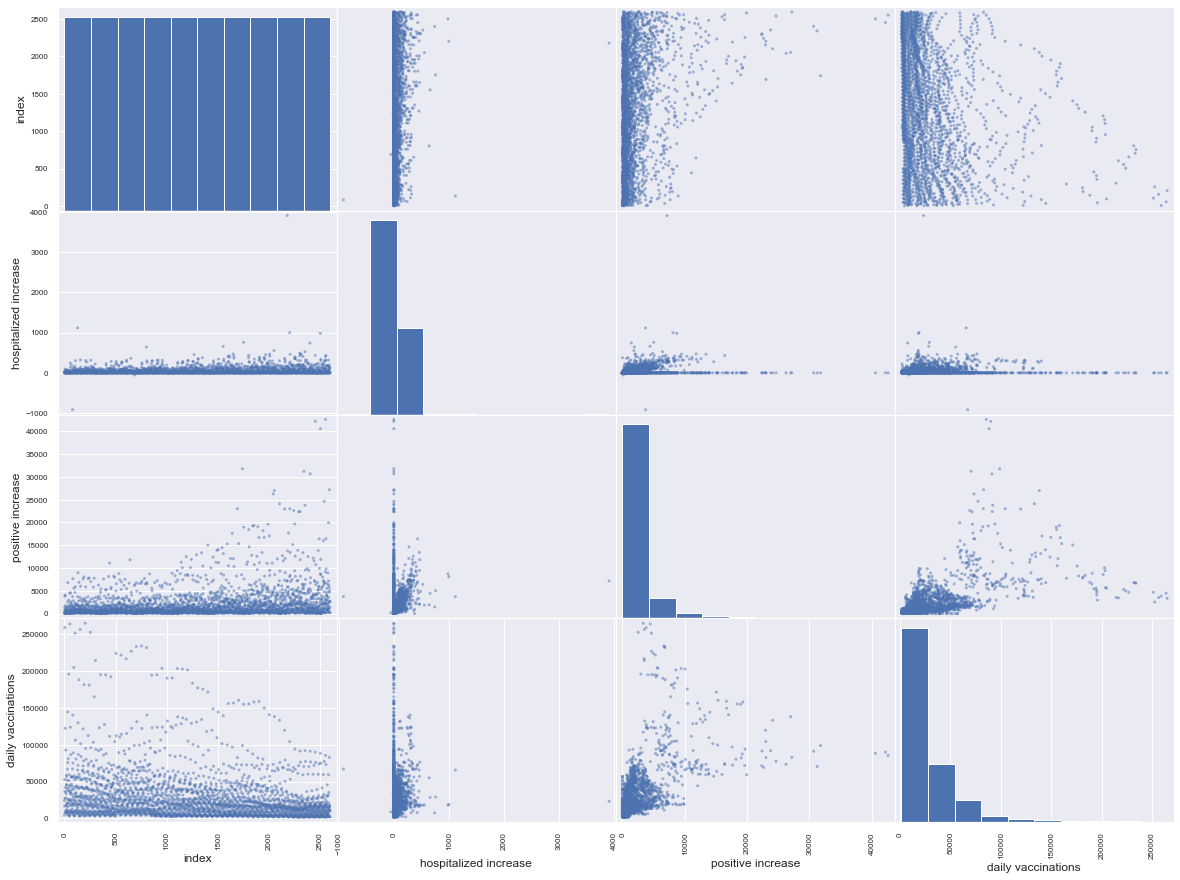

In [31]:
fig = pd.plotting.scatter_matrix(merged_data_smaller, figsize=(20, 15))

In [32]:
from scipy import stats
stats.pearsonr(utah_df['positive increase'], utah_df['daily vaccinations'])

(-0.20068787779457442, 0.1537064172356693)

In [33]:
utah_df.corr()

,index,hospitalized currently,hospitalized increase,positive,total test results,total test results increase,positive increase,total vaccinations,total distributed,people vaccinated,people fully vaccinated,daily vaccinations,hospital check
index,1.000000,0.976414,0.781644,-0.981017,-0.998017,0.421077,0.791290,-0.992657,-0.981112,-0.990353,-0.991892,-0.275903,NaN
hospitalized currently,0.976414,1.000000,0.789142,-0.982248,-0.982475,0.453932,0.796228,-0.974013,-0.928895,-0.962473,-0.963003,-0.278780,NaN
hospitalized increase,0.781644,0.789142,1.000000,-0.786038,-0.785648,0.628896,0.905510,-0.772971,-0.726321,-0.770216,-0.764631,-0.177952,NaN
positive,-0.981017,-0.982248,-0.786038,1.000000,0.990616,-0.411350,-0.799894,0.969240,0.934509,0.974520,0.958192,0.295546,NaN
total test results,-0.998017,-0.982475,-0.785648,0.990616,1.000000,-0.415301,-0.796257,0.990189,0.970807,0.989825,0.986552,0.288751,NaN
total test results increase,0.421077,0.453932,0.628896,-0.411350,-0.415301,1.000000,0.746735,-0.432336,-0.350499,-0.417458,-0.422241,-0.107668,NaN
positive increase,0.791290,0.796228,0.905510,-0.799894,-0.796257,0.746735,1.000000,-0.782395,-0.720462,-0.779178,-0.776920,-0.200688,NaN
total vaccinations,-0.992657,-0.974013,-0.772971,0.969240,0.990189,-0.432336,-0.782395,1.000000,0.978366,0.992553,0.995262,0.355895,NaN
total distributed,-0.981112,-0.928895,-0.726321,0.934509,0.970807,-0.350499,-0.720462,0.978366,1.000000,0.978911,0.985243,0.296048,NaN
people vaccinated,-0.990353,-0.962473,-0.770216,0.974520,0.989825,-0.417458,-0.779178,0.992553,0.978911,1.000000,0.987918,0.371479,NaN


# Ethics & Privacy

Regarding potential biases in our datasets, not every state may collect data with the same detail and thoroughness. Some regions may have fewer data-collection resources and are simply unable to provide highly-accurate data. As such, analysis based on hospital data may be biased toward regions that have more money, personnel, and space in their medical centers. Further, looking at testing and hospital data may exclude populations who have contracted COVID-19 but do not have the means to get tested. This may be problematic for equitable analysis because actions taken to get underperforming states to the same level as the states who are leading eradication of the disease may be misguided if the findings are biased. To handle this issue, we will seek data that accurately and equitably represents the population of the United States and datasets that are reliably reported.

There could potentially be an issue of patient privacy with the data we would like to use on vaccinations. If the data are not already anonymized to protect patient privacy, we would have to anonymize it prior to beginning exploratory data analysis and communicating our findings. Before analyzing the data we use, we will make sure to fully understand the information that is presented and identify where there may be bias or confounding factors. If any are identified, we will either incorporate appropriate new data into our analysis or seek new sources. When communicating our analysis, we will ensure that any potential misuses of our findings are addressed and that our analysis fully protects the privacy of patients involved.

# Conclusion & Discussion

*Fill in your discussion information here*

# Team Contributions

*Specify who in your group worked on which parts of the project.*